In [26]:
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent))

# import better_exceptions
from scikit_quri.qnn.regressor import QNNRegressor
import numpy as np
from typing import Optional
from quri_parts.circuit.utils.circuit_drawer import draw_circuit
from quri_parts.circuit import UnboundParametricQuantumCircuit,LinearMappedUnboundParametricQuantumCircuit
from numpy.random import default_rng

from qulacs import Observable
from quri_parts.core.operator import Operator, pauli_label
from quri_parts.core.estimator.gradient import create_parameter_shift_gradient_estimator
from quri_parts.qulacs.estimator import (
    create_qulacs_vector_estimator,
    create_qulacs_vector_parametric_estimator,
    create_qulacs_vector_concurrent_parametric_estimator,
    create_qulacs_vector_concurrent_estimator,
)
from quri_parts.algo.optimizer import Adam, LBFGS
from scikit_quri.circuit import LearningCircuit
from scikit_quri.circuit.pre_defined import create_farhi_neven_ansatz,create_qcl_ansatz

def generate_noisy_sine(x_min, x_max, num_x):
    rng = default_rng(0)
    x_train = [[rng.uniform(x_min, x_max)] for _ in range(num_x)]
    y_train = [np.sin(np.pi * x[0]) for x in x_train]
    mag_noise = 0.01
    y_train += mag_noise * rng.random(num_x)
    # return np.array(x_train), np.array(y_train)
    return np.array(x_train).flatten(), np.array(y_train)

x_train,y_train = generate_noisy_sine(-1.,1.,80)
x_test,y_test = generate_noisy_sine(-1.,1.,80)

In [27]:
from scikit_quri.circuit import LearningCircuit
from quri_parts.circuit.utils.circuit_drawer import draw_circuit
import matplotlib.pyplot as plt
n_qubits = 4
depth = 6
n_outputs = 1
# parametric_circuit = create_farhi_neven_ansatz(n_qubits,depth,1)
parametric_circuit = create_qcl_ansatz(n_qubits,depth,0.5,0)

op = Operator()
for i in range(n_outputs):
    op.add_term(pauli_label(f"Z {i}"),1.0)
draw_circuit(parametric_circuit.circuit)
# estimator = create_qulacs_vector_estimator()
estimator = create_qulacs_vector_concurrent_estimator()
gradient_estimator = create_parameter_shift_gradient_estimator(create_qulacs_vector_concurrent_parametric_estimator())
adam = Adam()

   ___     ___     ___     ___     ___     ___     ___     ___     ___     ___  
  |PRY|   |PRZ|   |Mat|   |PRX|   |PRZ|   |PRX|   |Mat|   |PRX|   |PRZ|   |PRX| 
--|0  |---|1  |---|8  |---|9  |---|10 |---|11 |---|21 |---|22 |---|23 |---|24 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    ___     ___     ___    |   |    ___     ___     ___  
  |PRY|   |PRZ|   |   |   |PRX|   |PRZ|   |PRX|   |   |   |PRX|   |PRZ|   |PRX| 
--|2  |---|3  |---|   |---|12 |---|13 |---|14 |---|   |---|25 |---|26 |---|27 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    ___     ___     ___    |   |    ___     ___     ___  
  |PRY|   |PRZ|   |   |   |PRX|   |PRZ|   |PRX|   |   |   |PRX|   |PRZ|   |PRX| 
--|4  |---|5  |---|   |---|15 |---|16 |---|17 |---|   |---|28 |---|29 |---|30 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    _

In [28]:
init_params = 2*np.pi*np.random.rand(parametric_circuit.n_learning_params)
print(init_params)

[5.50134044 3.95631665 3.42050532 5.58772787 0.15898841 5.47730172
 2.01258775 2.21190543 0.24459919 1.23931758 0.18991258 1.89901391
 2.67130534 2.94537743 2.91821035 2.37027366 3.55881619 2.06749852
 2.73528125 3.44722677 5.91654022 4.48410243 5.26522857 5.15894889
 3.35941962 0.12813857 5.04916949 2.25814902 4.18855751 4.25405738
 5.12327226 4.69697616 1.81234473 4.24019882 0.83471071 0.51826456
 1.59564566 0.53350391 0.08398821 3.30281611 0.39153644 2.15239045
 0.88983985 6.25516837 1.2039248  1.66224164 2.17201652 2.95395563
 3.39517448 0.70542436 5.47880657 1.19930744 1.213587   5.91792751
 5.41100109 5.47668788 3.76896823 2.37338744 4.37703603 3.55113425
 0.81178162 5.32476724 0.22429993 3.70285119 4.55643775 4.92254981
 0.93420967 0.6920589  0.27858238 1.13595579 3.62686916 1.03840327]


In [29]:
qnn = QNNRegressor(n_qubits,parametric_circuit,estimator,gradient_estimator,adam,op)

# qnn.grad_fn(x_train.reshape((-1,1)),y_train.reshape((-1,1)),params=init_params)
qnn.fit(x_train,y_train,maxiter=30)

parameter_count=72
init_params=array([4.46255071, 0.78326408, 2.68355714, 0.37370406, 0.28326329,
       1.16111197, 0.16687643, 0.70709825, 3.29120443, 0.91762678,
       2.48544623, 3.12922395, 5.85022251, 2.24574967, 2.22882728,
       1.92031009, 2.24505659, 3.52147524, 5.14408481, 3.54713402,
       5.04958754, 6.01355035, 1.39962911, 6.24042371, 4.59978885,
       5.73433501, 1.20943046, 4.50745528, 2.87190428, 4.11537038,
       4.15079382, 6.21056067, 2.52785276, 4.44075599, 4.56993502,
       0.32833173, 0.8139607 , 3.0153949 , 0.53575168, 1.28114954,
       5.26434673, 1.32727574, 2.16491778, 5.14085777, 4.40748508,
       5.3543284 , 3.82525197, 3.08879561, 0.89339763, 4.95179152,
       4.31888595, 3.69400789, 6.13600716, 0.13968269, 2.56195678,
       2.59985396, 5.93234601, 3.97435903, 1.5361204 , 4.42378481,
       2.5907001 , 0.5369391 , 2.14759425, 1.69998768, 0.94153927,
       3.47900984, 3.77698992, 4.08202007, 0.81481067, 4.15361022,
       2.3202495 , 0.65836324])

[[ 0.76578227  0.67528535]
 [-0.98730754 -0.93220695]
 [-0.24931674 -0.06454053]
 [-0.09580179  0.25992035]
 [ 0.92616326  0.94378498]
 [ 0.52847352  0.43308616]
 [ 0.62810709  0.52531338]
 [ 1.00103388  0.98054387]
 [ 0.27183373  0.17977365]
 [ 0.40402037  0.25499419]
 [ 0.92488576  0.93691945]
 [-0.00752639  0.43803529]
 [ 0.78095338  0.77843206]
 [-0.20082528  0.02845245]
 [ 1.00165299  0.98079554]
 [-0.88329702 -0.92117813]
 [ 0.75911628  0.74936328]
 [ 0.26729824  0.16758748]
 [-0.942715   -0.88036023]
 [-0.45866614 -0.4581298 ]
 [-0.17220038  0.09770549]
 [-0.70159157 -0.75507634]
 [ 0.88620881  0.81827363]
 [ 0.80774711  0.7217575 ]
 [ 0.66578629  0.57020032]
 [-0.66213242 -0.6244751 ]
 [ 0.02195712 -0.04894921]
 [ 0.1294345  -0.12635993]
 [ 0.91950685  0.87128877]
 [ 0.81802987  0.73609516]
 [ 0.93228329  0.88075873]
 [-0.64234734 -0.60368508]
 [-0.74331973 -0.80295692]
 [ 0.98415649  0.96643653]
 [ 0.16621245  0.07698467]
 [-0.92408837 -0.85685449]
 [-0.07959058 -0.14094563]
 

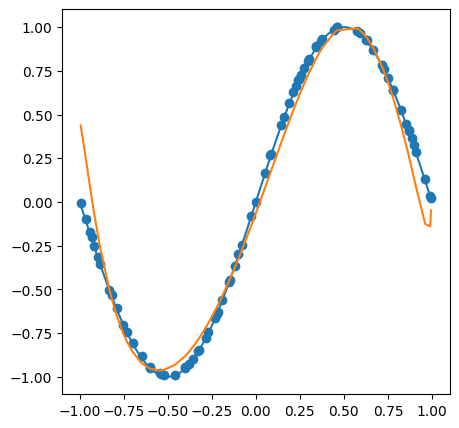

In [30]:
y_pred = qnn.predict(x_test)
y_test = y_test.reshape(-1,1)
plt.figure(figsize=(5,5))

print(np.array([[test[0],pred[0]] for test,pred in zip(y_test,y_pred)]))
# plt.plot(x_test,y_test,marker="o",color="orange",label="Test")
plt.scatter(
    np.sort(x_test),
    y_test[np.argsort(x_test.flatten())],label="Test")

x_true = np.linspace(-1,1,100)
y_true = np.sin(np.pi * x_true)
plt.plot(x_true,y_true,label="True")
plt.plot(
    np.sort(x_test.flatten()),
    y_pred[np.argsort(x_test.flatten())],
    label="Prediction")
# plt.legend()
from sklearn.metrics import mean_squared_error
cost = mean_squared_error(y_test,y_pred)
print(f"{cost=}")
plt.show()